# PHYS3116 Computational Assessment: Area 51 Interns

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Introduction to assessment
**Accreted Milky Way Globular Clusters**

Using data from the Harris Catalogue of Milky Way globular clusters and vandenBerg et al. (2013), use
stellar population (metallicities [Fe/H] and ages) and dynamical information to identify potentially
accreted globular clusters. Consider if there are some globular clusters that stand out in the agemetallicity relation or that do not rotate with the bulk of other globular clusters.

Consider what the above findings might mean for how the Milky Way formed and how many of its
globular clusters could be accreted and how many may have formed within the Milky Way. Consider
what further tests could be performed to delineate various possible formation scenarios.

Reformatted .csv versions of relevant data tables have been uploaded to Moodle for convenience.

## Introduction to this file
This file investigates potential accreted globular clusters through co-rotation the clusters


To get co-rotation we need to do the following steps:
1. Convert radial velocity into the galactic standard of rest so it is no longer relative to the sun or our solar system but to the galaxy
2. We obtain the average rotation formula for the average rotation patterns of each cluster through Galaxy LOS velocity
3. We apply this formula to each cluster for a projected velocity based on its coordinates
4. For each cluster, we compare projected and actual Galaxy LOS Velocity and we determine co-rotation through it

## 0) Merging CSV files

In [284]:
harris1 = pd.read_csv('HarrisPartI.csv')
harris3 = pd.read_csv('HarrisPartIII.csv')
merge = pd.merge(harris1, harris3, on='ID', how='outer')
merge.head()

,ID,Name,RA,DEC,L,B,R_Sun,R_gc,X,Y,...,v_LSR,sig_v,sig_v_e,c,r_c,r_h,mu_V,rho_0,lg_tc,lg_th
0,1636-283,ESO452-SC11,16:39:25.45,-28:23:55.3,351.91,12.10,8.3,2.1,8.0,-1.1,...,NaN,NaN,NaN,1.00,0.50,0.50,20.75,2.50,8.07,7.87
1,2MS-GC01,2MASS-GC01,18:08:21.81,-19:49:47,10.48,0.11,3.6,4.5,3.5,0.7,...,NaN,NaN,NaN,0.85,0.85,1.65,NaN,NaN,NaN,8.43
2,2MS-GC02,2MASS-GC02,18:09:36.50,-20:46:44,9.79,-0.61,4.9,3.2,4.9,0.8,...,-227.4,NaN,NaN,0.95,0.55,0.55,NaN,NaN,NaN,7.72
3,AM 1,E 1,03:55:02.3,-49:36:55,258.34,-48.47,123.3,124.6,-16.5,-80.1,...,101.3,NaN,NaN,1.36,0.17,0.41,23.62,0.03,8.96,9.61
4,AM 4,NaN,13:56:21.7,-27:10:03,320.28,33.51,32.2,27.8,20.7,-17.2,...,NaN,NaN,NaN,0.70,0.41,0.43,24.75,-0.05,8.42,8.32


## 1) Extracting data from .csv files


The data columns we need are:
- l and b for positions and projections
- $v_{lsr}$, as it is 'Radial velocity relative to Solar neighborhood LSR', so we dont need to take in account the sun's deviations in movement. So we use this instead of $v_r$
- Additionally we will remove data that has NA for $v_{LSR}$ as we are unable to use such data for our purposes

In [285]:
# We choose right columns that we care about
rotation_data = merge[['ID', 'L', 'B', 'v_LSR', 'R_Sun']]

# Get rid of rows we dont care about, because we lack the v_LSR for them
rotation_data = rotation_data.dropna(subset=['v_LSR'])
rotation_data.head()


,ID,L,B,v_LSR,R_Sun
2,2MS-GC02,9.79,-0.61,-227.4,4.9
3,AM 1,258.34,-48.47,101.3,123.3
5,Arp 2,8.55,-20.79,122.4,28.6
8,Djorg 1,356.69,-2.47,-355.0,13.7
12,Eridanus,218.10,-41.33,-39.1,90.1


## 2) Conversion to Galactic Standard of Rest

Now we convert $v_{LSR}$ in to $v_{GSR}$. This is done by the following formula:

$v_{GSR} = v_{LSR} + v_{LSR}\cdot r = v_{LSR} + V_{0}sin(l)cos(b)$

This comes from adding the LSR frame velocity to the dot product of the LSR LOS velocity and the radial component of GSR.

where $V_{0}$ = 230 km/s, which is tangential component of Sun's motion with respect to the galactic center

Now we append this to the data:

In [286]:
V_0 = 230
l = np.radians(rotation_data['L'])
b = np.radians(rotation_data['B'])
rotation_data['v_GSR'] = (
    rotation_data['v_LSR'] +
    V_0*np.sin(l)*np.cos(b)
)
rotation_data.head()

,ID,L,B,v_LSR,R_Sun,v_GSR
2,2MS-GC02,9.79,-0.61,-227.4,4.9,-188.293589
3,AM 1,258.34,-48.47,101.3,123.3,-48.045966
5,Arp 2,8.55,-20.79,122.4,28.6,154.368165
8,Djorg 1,356.69,-2.47,-355.0,13.7,-368.267464
12,Eridanus,218.10,-41.33,-39.1,90.1,-145.669034


## 3) Obtain Galactrocentric cylindrical radius

To obtain our predicted GSR, we require the top down radius and the following formula obtains this:

$R = \sqrt{R_{0}^2 + (R_{sun}cos(b))^2-2R_0R_{sun}cos(b)cos(l)}$

Where $R_{0} = 8.2kpc$, the distance between galactic center and the sun.

The formula comes from the cosine rule with a triangle with corners of sun center, galactic center, and the in plane position of the cluster. The sides being $R_{sun}cos(b)$, $R_{0}$ and $R$ with angle $l$ opposite $R$.



In [287]:
R0 = 8.2
rotation_data['R'] = (
  np.sqrt(
    R0**2 + 
    (rotation_data['R_Sun']*np.cos(b))**2 - 
    2 * R0 * rotation_data['R_Sun'] * np.cos(b) * np.cos(l)
  )
)
rotation_data.head()

,ID,L,B,v_LSR,R_Sun,v_GSR,R
2,2MS-GC02,9.79,-0.61,-227.4,4.9,-188.293589,3.473039
3,AM 1,258.34,-48.47,101.3,123.3,-48.045966,83.792372
5,Arp 2,8.55,-20.79,122.4,28.6,154.368165,18.668765
8,Djorg 1,356.69,-2.47,-355.0,13.7,-368.267464,5.521288
12,Eridanus,218.10,-41.33,-39.1,90.1,-145.669034,74.283137


## 4) Obtain modelled GSR velocity 

Assuming circular velocity is a flat curve for simplification, as we only care about corotation:

$V_c(R) = 230km/s$

We can obtain the modelled GSR with the following formula:

$V^{GSR}_{model} = \frac{R_0}{R}V_c(R)sin(l)cos(b)$

Which comes from the projection of the predicted velocity into the line of sight of Galactic Center frame.

In [288]:
V_c = 230
rotation_data['v_GSRmodel'] = (
  ((R0/rotation_data['R']) * V_c - V_0) * 
  np.sin(l) * 
  np.cos(b)
)
rotation_data.head()

,ID,L,B,v_LSR,R_Sun,v_GSR,R,v_GSRmodel
2,2MS-GC02,9.79,-0.61,-227.4,4.9,-188.293589,3.473039,53.225562
3,AM 1,258.34,-48.47,101.3,123.3,-48.045966,83.792372,134.730830
5,Arp 2,8.55,-20.79,122.4,28.6,154.368165,18.668765,-17.926585
8,Djorg 1,356.69,-2.47,-355.0,13.7,-368.267464,5.521288,-6.436852
12,Eridanus,218.10,-41.33,-39.1,90.1,-145.669034,74.283137,94.805044


## 5) Residuals and Co-Rotation test
We find the residuals and flag non-corotators:

$\Delta v = v_{GSR} - v_{model}^{GSR}$

This value 

In [289]:
rotation_data['v_delta'] = rotation_data['v_GSR'] - rotation_data['v_GSRmodel']
rotation_data.head()

,ID,L,B,v_LSR,R_Sun,v_GSR,R,v_GSRmodel,v_delta
2,2MS-GC02,9.79,-0.61,-227.4,4.9,-188.293589,3.473039,53.225562,-241.519152
3,AM 1,258.34,-48.47,101.3,123.3,-48.045966,83.792372,134.730830,-182.776796
5,Arp 2,8.55,-20.79,122.4,28.6,154.368165,18.668765,-17.926585,172.294750
8,Djorg 1,356.69,-2.47,-355.0,13.7,-368.267464,5.521288,-6.436852,-361.830612
12,Eridanus,218.10,-41.33,-39.1,90.1,-145.669034,74.283137,94.805044,-240.474078


Additionally as we are using line of sight velocity, perpendicular movement to the radius would have a lower signal, thus we remove them as the data is unreliable.

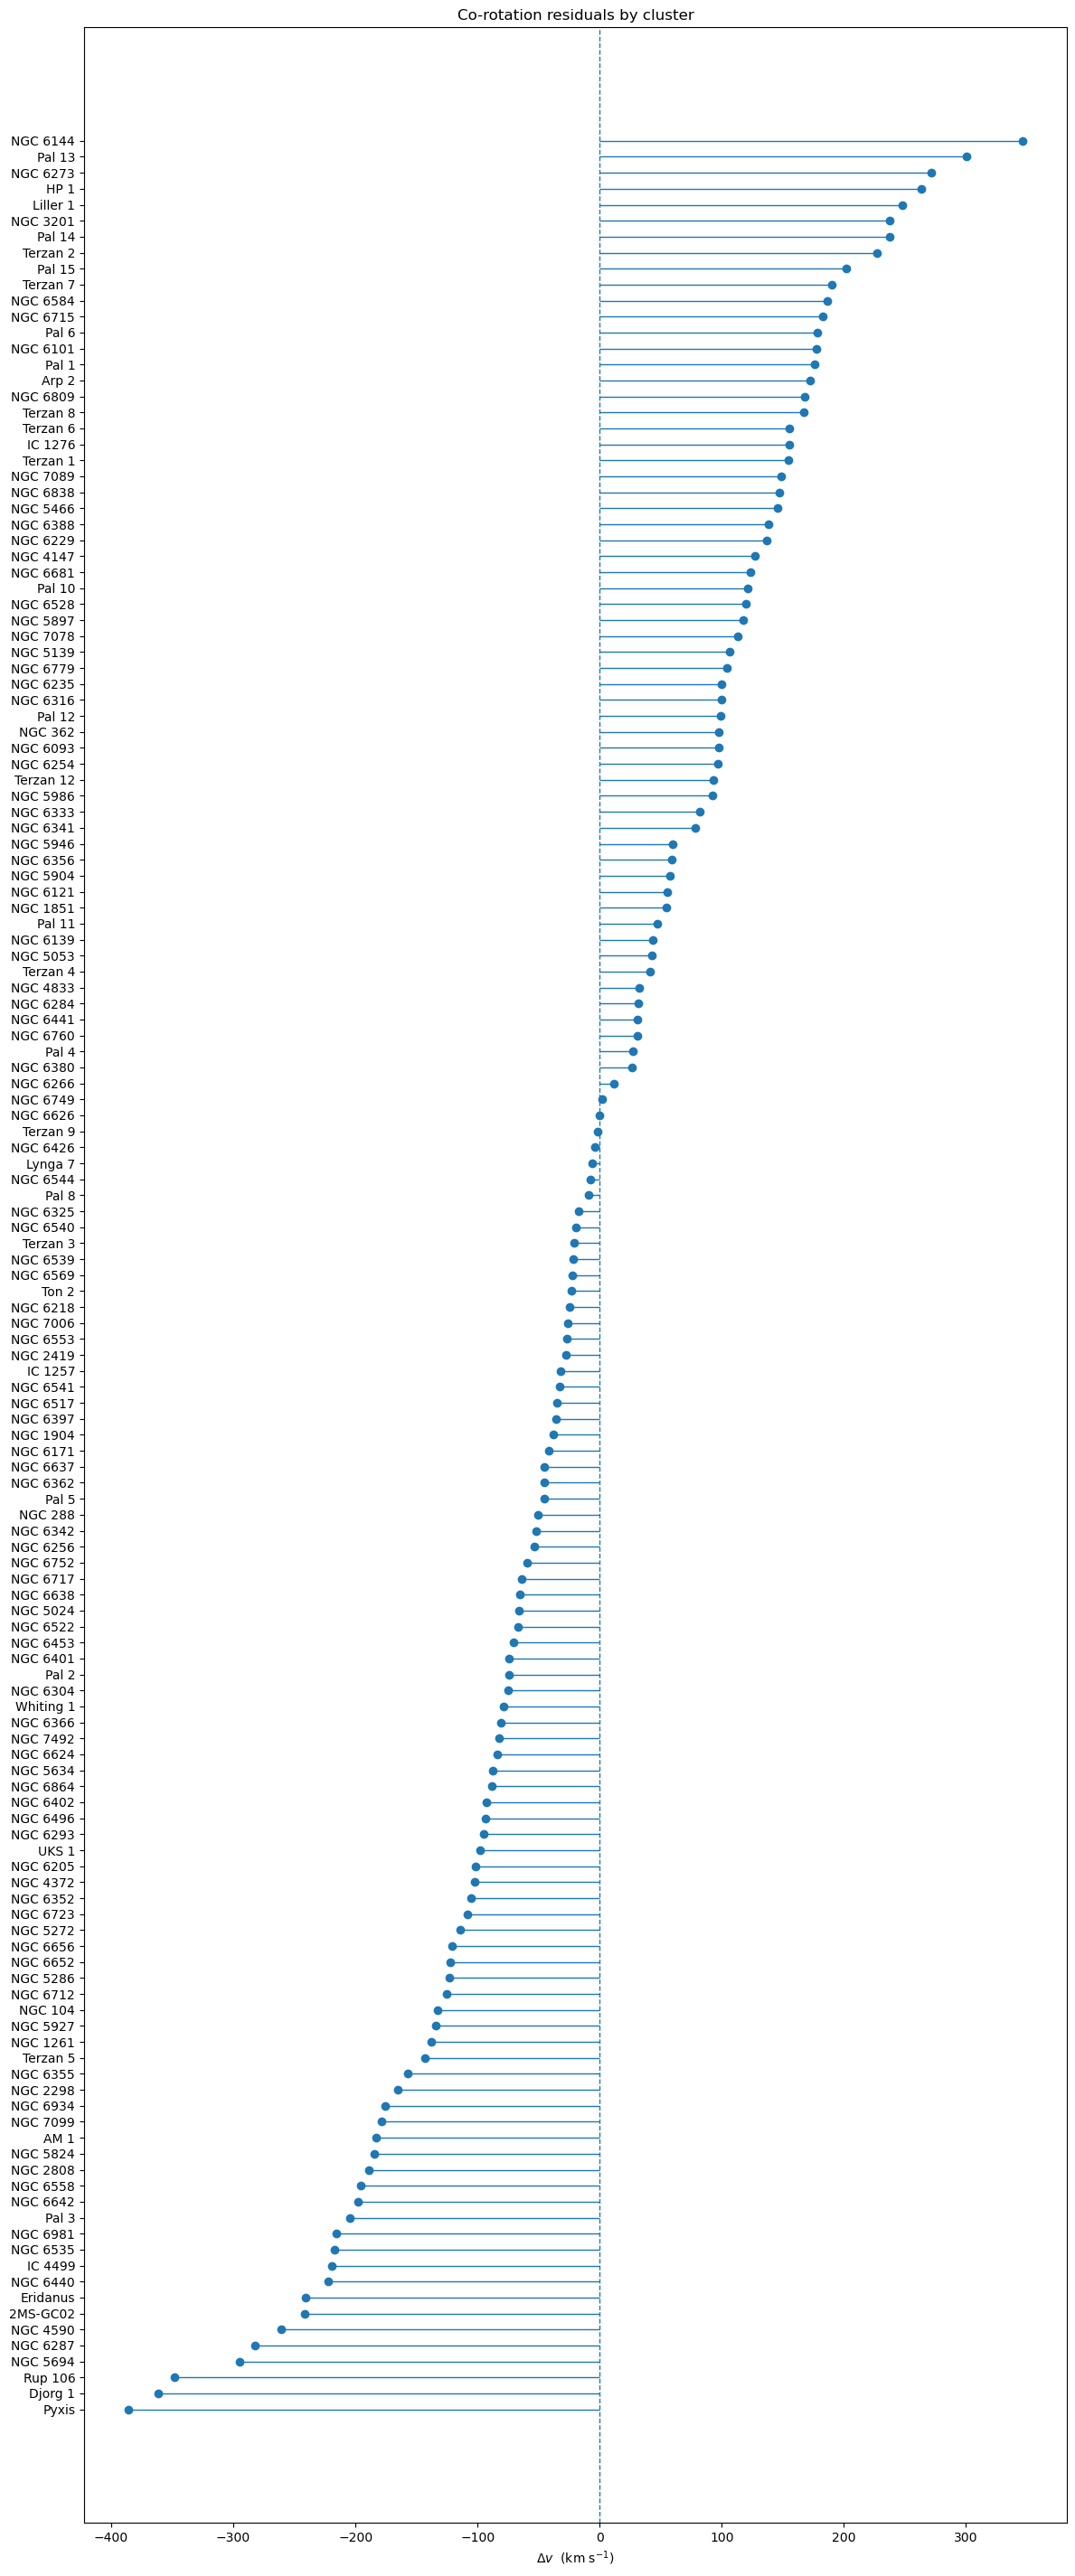

In [290]:
results = rotation_data[['ID', 'v_delta']].dropna().sort_values('v_delta')
results = results.sort_values('v_delta')                       

y = np.arange(len(results))
fig, ax = plt.subplots(figsize=(12, max(4, len(results)*0.2)))

# lollipop display things
ax.hlines(y, 0, results['v_delta'], linewidth=1)
ax.plot(results['v_delta'], y, 'o')

# zero line in the middle
ax.axvline(0, linestyle='--', linewidth=1)

ax.set_yticks(y)
ax.set_yticklabels(results['ID'])

ax.set_xlabel(r'$\Delta v$  (km s$^{-1}$)')

ax.set_title('Co-rotation residuals by cluster')
plt.tight_layout()
plt.show()


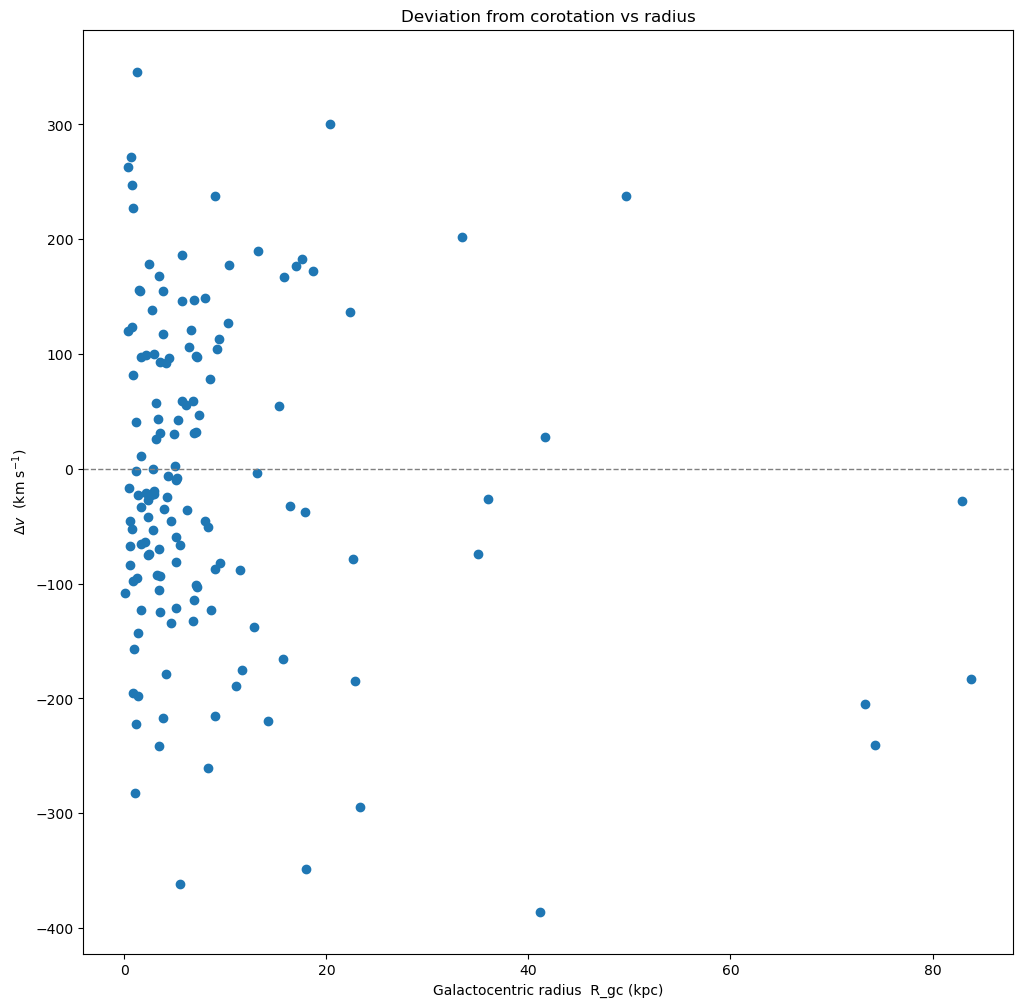

In [291]:
plt.figure(figsize=(12,12))
plt.axhline(0, ls='--', lw=1, color='gray')

plt.scatter(rotation_data['R'], rotation_data['v_delta'])
plt.xlabel('Galactocentric radius  R_gc (kpc)')
plt.ylabel(r'$\Delta v$  (km s$^{-1}$)')
plt.title('Deviation from corotation vs radius')
plt.show()

With the graphs we obtained, it appears that there is no consensus of co-rotation as the effects are very spread out. We expected most of the globulars to be around the mean velocity for rotation with accreted being the outliers however the data shows implies otherwise. A reason could be that the mean rotation speed of Milky Way globular clusters is too small to have a consensus corotation for us to use, and thus we are unable to accurately use co-rotation to determine accreted globular systems.